In [ ]:
!pip install git+https://github.com/pantelis-classes/PRML.git#egg=prml

import pandas as pd
from pandas.core.dtypes.dtypes import CategoricalDtype
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from prml.preprocess import GaussianFeature, PolynomialFeature, SigmoidalFeature
from prml.linear import LinearRegression

from xgboost import XGBRegressor

import jax
import jax.numpy as jnp

import warnings
warnings.filterwarnings('ignore')

  Cloning https://github.com/pantelis-classes/PRML.git to /tmp/pip-install-92pe90sy/prml_6e37f64c1bfc47349aa3b1a779c19815
  Running command git clone -q https://github.com/pantelis-classes/PRML.git /tmp/pip-install-92pe90sy/prml_6e37f64c1bfc47349aa3b1a779c19815


# 1.0 Data Exploration

In [ ]:
# Read our train data for data visualization
train_df = pd.read_csv("https://raw.githubusercontent.com/hahdookin/cs301/main/train.csv", index_col='Id')

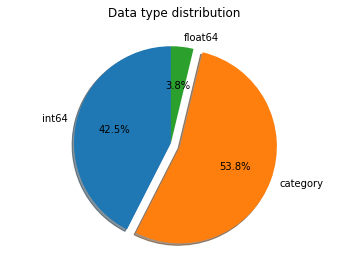

In [ ]:
# Through the following pie chart, it is evident that over half of our dataset
# consists of non-numeric columns, which will not be used in a regression algorithm.

# After visualizing the amount of categorical data, it is clear that simply ignoring
# columns that contain categorical data will severly hinder the success of our 
# model. We will eventually need to develop a strategy for encoding the categorical
# data types to numeric values that the regression model can work with.

# Pie chart to visualize numeric types vs categorical types
train_df.dtypes.unique()[0].name

dtypes = [dtype.name for dtype in train_df.dtypes.unique()]
counts = [len(train_df.select_dtypes(dtype).iloc[0]) for dtype in dtypes]
explode = [0.1 if dtype == 'object' else 0 for dtype in dtypes]
dtypes = [name if name != 'object' else 'category' for name in dtypes]
fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=dtypes, autopct='%1.1f%%', shadow=True, startangle=90, explode=explode)
ax1.axis('equal')

plt.title('Data type distribution', pad=20)
plt.show()

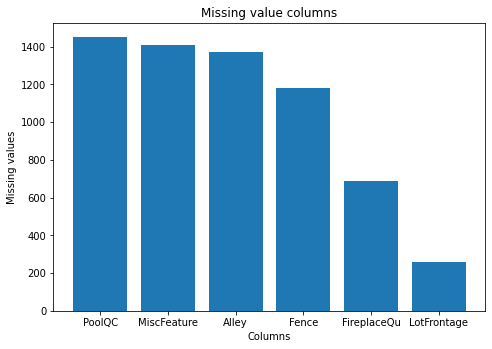

In [ ]:
# In order to think about how to handle missing values in the dataset, we are going
# to chart which columns have the most missing values. By doing this, we are able 
# to determine a strategy for handling the missing values.

# Grab all the columns with missing values and find how NA values are in each row
cols_with_na = {}
for col in train_df:
  if train_df[col].isna().any():
    cols_with_na[col] = sum(train_df[col].isna())

# Filter out colums with not a lot of missing values (prettier graph)
remove = [k for k,v in cols_with_na.items() if v < 200]
for k in remove:
  cols_with_na.pop(k)

# Sort values in descending order
cols_with_na = {k: v for k, v in sorted(cols_with_na.items(), key=lambda item: item[1], reverse=True)}

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(cols_with_na.keys(), cols_with_na.values())
plt.title('Missing value columns')
plt.xlabel('Columns')
plt.ylabel('Missing values')
plt.show()

# 1.1 Data Preprocessing

In [ ]:
#data preprocess with label encoding and one-hot encoding
from pandas.core.dtypes.dtypes import CategoricalDtype

def InitData(encoding):
  df = pd.read_csv("https://raw.githubusercontent.com/hahdookin/cs301/main/train.csv", index_col='Id')

  # Drop ID column
  if 'Id' in df.columns:
    df = df.drop('Id', axis=1)

  # Fix typo in dataset
  df['Exterior2nd'] = df['Exterior2nd'].replace({'Brk Cmn': 'BrkComm'})

  # Now, we need to go through the data and split the categorical columns that
  # have a natural ordering (ordinal) and those that do not (nominative)
  nominative_features = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 
    'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
    'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 
    'SaleType', 'SaleCondition'
  ]

  # Commonly used values for 5 and 10 quality levels
  quality5 = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
  quality10 = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
  
  # All ordinal category lists go from best to worst.
  # i.e. Gd -> 0, Av -> 1, Mn -> 2, etc.
  ordinal_features = {
    'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
    'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
    'LandSlope': ['Gtl', 'Mod', 'Sev'],
    'OverallQual': quality10,
    'OverallCond': quality10,
    'ExterQual': quality5,
    'ExterCond': quality5,
    'BsmtQual': quality5,
    'BsmtCond': quality5,
    'BsmtExposure': ['Gd', 'Av', 'Mn', 'No'],
    'BsmtFinType1': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'],
    'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'],
    'HeatingQC': quality5,
    'Electrical': ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'],
    'KitchenQual': quality5,
    'Functional': ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],
    'FireplaceQu': quality5,
    'GarageFinish': ['Fin', 'RFn', 'Unf'],
    'GarageQual': quality5,
    'GarageCond': quality5,
    'PavedDrive': ['Y', 'P', 'N'],
    'PoolQC': quality5,
    'Fence': ['GdPrv', 'MnPrv', 'GdWo', 'MnWw'],
  }

  # Add 'None' as a possible category to be used to assign missing values to.
  for key, val in ordinal_features.items():
    if 'None' not in ordinal_features[key]:
      ordinal_features[key] = val + ['None'];
  
  # Convert nominative features to category
  for col in nominative_features:
    df[col] = df[col].astype('category')
    if 'None' not in df[col].cat.categories:
      df[col].cat.add_categories('None', inplace=True)
    
  for col, values in ordinal_features.items():
    df[col] = df[col].astype(CategoricalDtype(values, ordered=True))

  # Impute ALL missing values in categorical types to simply be 'None'
  for col in df.select_dtypes('category'):
    df[col] = df[col].fillna('None')

  # Impute numerical features
  # LotFrontage can be set to 0 (House has 0 feet of street connected to it)
  df['LotFrontage'] = df['LotFrontage'].fillna(0)
  # MasVnrArea can be set to 0 (House has no masonry veneer, so 0 sqft)
  df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
  # GarageYrBuilt can be set to the year the house was built
  # (Would not make sense to set these missing values to 0)
  df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

  # Confirm we aren't missing any values
  assert len([v for v in df.isna().any() if v]) == 0, "Still missing values"

  # Apply the appropriate encoding
  if encoding == 'label':
    # handle label encoding
    for col in df.select_dtypes('category'):
      df[col] = df[col].cat.codes
  elif encoding == 'onehot':
    # Store SalePrice
    saleprice = df['SalePrice']
    df = df.drop('SalePrice', axis=1)
    # handle one hot
    for col in df.select_dtypes('category'):
      dummies = pd.get_dummies(df[col], prefix=col)
      df = df.drop(col, axis=1)
      df = df.join(dummies)
    df = df.join(saleprice)
  elif encoding == 'both':
    # one-hot nominative
    saleprice = df['SalePrice']
    df = df.drop('SalePrice', axis=1)
    for col in nominative_features:
      dummies = pd.get_dummies(df[col], prefix=col)
      df = df.drop(col, axis=1)
      df = df.join(dummies)
    df = df.join(saleprice)
    # label encode ordinals
    for col in ordinal_features.keys():
      df[col] = df[col].cat.codes

  return df

def rmse(pred, test):
  test = test.to_numpy()
  return jnp.mean(jnp.sqrt(jnp.square(pred - test)))

In [ ]:
#preliminary cross validation: using cross validation & linear regression
lr = linear_model.LinearRegression()

In [ ]:
#preliminary cross validation: the training data was used for this preliminary step
trainCrossVal_df = pd.read_csv("https://raw.githubusercontent.com/hahdookin/cs301/main/train.csv")

print(trainCrossVal_df.shape)

trainCrossVal_df = InitData('label')

#print(train_df.shape)

lr = linear_model.LinearRegression()
X, y = trainCrossVal_df.iloc[:, :-1].values, trainCrossVal_df.iloc[:, -1]

(1460, 81)


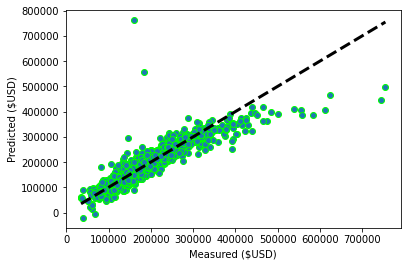

In [ ]:
# preliminary experiment: plotting and view of the fit applied on data
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation

predictedCrossVal = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predictedCrossVal, edgecolors=(0, 1, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=3)
ax.set_xlabel("Measured ($USD)")
ax.set_ylabel("Predicted ($USD)")
plt.show()

# 1.2 Feature Transformation

In [ ]:
#Here we build our data frame, encode it by passing either "onehot", "label", or "both" through InitData(), then split it into training and testing data

transform = False #boolean which determines whether or not a polynomial transformation will be applied to the data

train_df = InitData("both")

if(transform):
  features = 10 #how many columns in the data frame to train the regression models with
  M = 2 #the degree of the polynomial which we will transform the df to

  corr = train_df.corr()
  corr.sort_values(["SalePrice"], ascending = False, inplace = True)


  y = train_df.iloc[:,-1]
  train_df = train_df[corr.SalePrice.keys()[1:features + 1]]
  X = train_df.iloc[:, :]
  

  feature = PolynomialFeature(M)

  X= train_df.iloc[:, :-1].values
  x_train, x_test, y_train, y_test = train_test_split(X,y)

  X_train, X_test = feature.transform(x_train), feature.transform(x_test)

  
  
else:
  X, y = train_df.iloc[:, :-1].values, train_df.iloc[:, -1]
  X_train, X_test, y_train, y_test = train_test_split(X,y)




In [ ]:
X_train.shape

(1095, 254)

In [ ]:
#check most closely correlated features to sale price for each encoding
train_df = InitData("label")
corr = train_df.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)
print(corr.SalePrice.keys()[-11:-1])

SalePrice       1.000000
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
                  ...   
GarageFinish   -0.549247
BsmtQual       -0.585207
KitchenQual    -0.659600
ExterQual      -0.682639
OverallQual    -0.790982
Name: SalePrice, Length: 80, dtype: float64
Index(['GarageQual', 'BsmtFinType1', 'BsmtExposure', 'GarageType', 'HeatingQC',
       'FireplaceQu', 'GarageFinish', 'BsmtQual', 'KitchenQual', 'ExterQual'],
      dtype='object')


# 2.0 Jax Linear Regression

In [ ]:
#Basic linear regression following tutorial from https://coax.readthedocs.io/en/latest/examples/linear_regression/jax.html

def forwardPass(params, X):
  return jnp.dot(X, params['w']) + params['b']

def jreg(X, y, learning_rate, iterations, verbose, plot):

  y = y.to_numpy()

  params = {'w': jnp.zeros(X.shape[1:]),
            "b" : 0. 
  }       

  def loss_fn(params, X, y):
    err = forwardPass(params, X) - y
    return jnp.mean(jnp.sqrt(jnp.square(err)))

  grad_fn = jax.grad(loss_fn)

  eta = learning_rate #0.0001 

  def update(params, grads):
    return jax.tree_multimap(lambda p, g: p - eta * g, params, grads)

  tl = []
  for _ in range(iterations):
    loss = loss_fn(params, X, y) 
    grads = grad_fn(params, X, y)
    params = update(params, grads)
    tl.append(loss)
    if(verbose):
      print(loss)
  if(plot):
    f = plt.figure()
    plt.plot(tl)
    plt.xlabel("Epoch")
    plt.ylabel('Training loss')
    plt.show()

    print("Final Loss: " + str(loss))
  return params

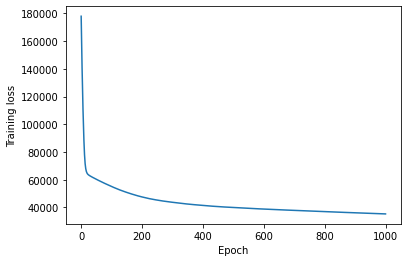

Final Loss: 35292.47
Test loss: 43690.387


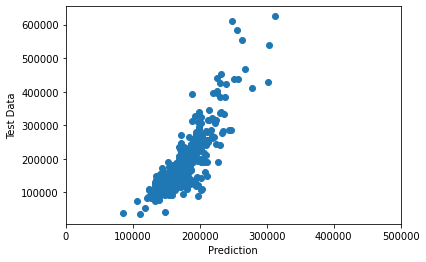

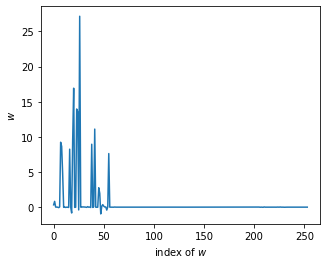

In [ ]:
#call to linear regression model built with jax
params = jreg(X_train, y_train, learning_rate = 0.0001, iterations = 1000, verbose = False, plot = True) #learning rate may have to be tweaked depending on data processing, in general the more columns in X_train the smaller the learning rate should be
print("Test loss: "  + str(rmse(forwardPass(params, X_test), y_test)))

plt.figure()
plt.scatter(forwardPass(params, X_test), y_test)
plt.xlabel("Prediction")
plt.ylabel("Test Data")
plt.xlim(0, 500000)
plt.show()

plt.figure(figsize=[5,4])
plt.plot(params['b'] + params['w']) 
plt.xlabel("index of $w$")
plt.ylabel("$w$")
plt.show()

# 2.1 XGBRegressor

Mean squared error: 17968.025


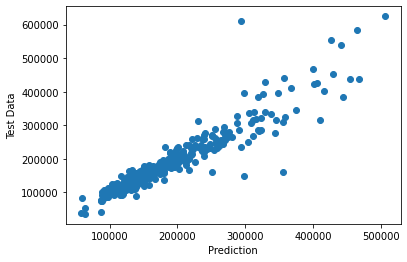

In [ ]:
#xgbregressor call
#model = XGBRegressor()
model = XGBRegressor(colsample_bytree = 0.87, eta = 0.001, max_depth=4, n_estimators=111, subsample=0.4207, verbosity=0) # verbosity set to 0 to suppress warnings
#model = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                            #  learning_rate=0.05, max_depth=3, 
                            #  min_child_weight=1.7817, n_estimators=2200,
                            #  reg_alpha=0.4640, reg_lambda=0.8571,
                            #  subsample=0.5213, silent=1,
                            #  random_state =7, nthread = -1) 
model.fit(X_train, y_train)
prediction = model.predict(X_test)

print("Mean squared error: " + str(rmse(prediction, y_test)))
f = plt.figure()
plt.scatter(prediction, y_test)
plt.ylabel("Test Data")
plt.xlabel("Prediction")
plt.show()


# 2.2 Implementation of Linear Regression from "Pattern Recognition and Machine Learning"

Mean squared error: 22467.404


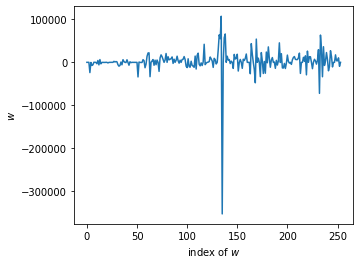

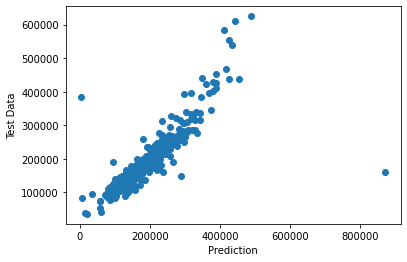

In [ ]:
#linear regression from pmrl

model = LinearRegression()
model.fit(X_train, y_train)


plt.figure(figsize=[5,4])
plt.plot(model.w) 
plt.xlabel("index of $w$")
plt.ylabel("$w$")

y, y_std = model.predict(X_test, return_std=True)

print("Mean squared error: " + str(rmse(y, y_test)))

f = plt.figure()
plt.scatter(y, y_test)
plt.ylabel("Test Data")
plt.xlabel("Prediction")
plt.show()


# plt.figure(figsize=[10,8])

# plt.scatter(X_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
# plt.plot(x_test, y, label="mean")
# plt.fill_between(
#     x_test, y - y_std, y + y_std,
#     color="orange", alpha=0.5, label="std.")
# plt.legend()
# plt.xlabel("$x$")
# plt.ylabel("$y$")

# plt.show()

# 3.0 Hyper-parameter Tuning of XGBRegressor

In [ ]:
#hyperparameter tuning using hyperopt

def objectiveXGBR(space):
    reg = XGBRegressor(n_estimators=int(space['n_estimators']), 
        max_depth=int(space['max_depth']), 
        eta=space["eta"], 
        colsample_bytree = space["colsample_bytree"],
        subsample = space["subsample"],
        verbosity = 0)

    ts = [(X[X.shape[0]//2:], y[y.shape[0]//2:]), (X[:X.shape[0]//2], y[:y.shape[0]//2])] #training
    
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse', verbose=False)

    yhat = reg.predict(X_test)
    accuracy = mean_squared_error(y_test, yhat, squared = False)

    #print ("SCORE:", accuracy)
    return {'loss': accuracy, 'status': STATUS_OK }


spaceXGBR={'max_depth': hp.quniform("max_depth", 0, 20, 1),
        'eta' : hp.choice("eta", [0.3, 0.1, 0.001, 0.003]),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'n_estimators': hp.quniform("n_estimators", 5, 200, 1),
        'subsample': hp.uniform("subsample", 0.4, .9)
    }



trials = Trials()


best_hyperparams = fmin(fn = objectiveXGBR,
                        space = spaceXGBR,
                        algo = tpe.suggest,
                        max_evals = 500,
                        trials = trials,
                        verbose=False)
print("The best hyperparameters are : ","\n")
print(best_hyperparams)


 71%|███████▏  | 357/500 [10:12<04:45,  1.99s/it, best loss: 26889.189473398466]

In [ ]:
#linear regression in jax

#main question we need to answer is how many parameters we want to use

def jreg_boost(X, y, num_estimators, learning_rate, iterations, verbose = False): #pass num_estimators, eta, iterations, (possibly num_parameters)
  eta = learning_rate #should this be passed through jreg() as a parameter so that we can tune it with hyperopt? We can also pass, iterations as a parameter

  y = y.to_numpy()
  params = {'w': jnp.zeros(X.shape[1:]),
            "b" : 0. 
  } 


  def forwardPass(params, X):
    return jnp.dot(X, params['w']) + params['b'] #not working as of right now, definitely a result of the X which gets passed through, issue is with data set itself


  def loss_fn(params, X, y, previous_loss):
    err = forwardPass(params, X) - y
    #err = jnp.dot(err, previous_loss)
    err += previous_loss
    return jnp.mean(jnp.sqrt(jnp.square(err)))

  def loss_fn_org(params, X, y):
    err = forwardPass(params, X) - y
    return jnp.mean(jnp.sqrt(jnp.square(err)))

  grad_fn = jax.grad(loss_fn)



  def update(params, grads):
    return jax.tree_multimap(lambda p, g: p - eta * g, params, grads)
  
  prev_loss = jnp.ones(X.shape[0])
  
  tl = []
  for __ in range(num_estimators):      
    for _ in range(iterations):
      loss = loss_fn_org(params, X, y) #we can also save these values to a list and track training loss over each iteration

      if(verbose):
        print(loss)
        #print(params)
      tl.append(loss)
      grads = grad_fn(params, X, y, prev_loss)
      params = update(params, grads)

    if verbose:
      print("Error of estimator " + str(__) + ": " + str(loss))
    curr_loss = forwardPass(params, X) - y
    prev_loss = (curr_loss-min(curr_loss))/(max(curr_loss) - min(curr_loss))
    prev_loss = (prev_loss-min(prev_loss))/(max(prev_loss) - min(prev_loss))
  f = plt.figure()
  plt.plot(tl)
  plt.xlabel("Epoch")
  plt.ylabel('Training loss')
  plt.show()
  return params


In [ ]:
#call to linear regression model built with jax
params = jreg_boost(X_train, y_train, num_estimators = 250, learning_rate = 0.00001, iterations = 50, verbose = False) #learning rate may have to be tweaked depending on data processing, in general the more columns in X_train the smaller the learning rate should be
print("Test loss: "  + str(rmse(forwardPass(params, X_test), y_test)))

plt.figure()
plt.scatter(forwardPass(params, X_test), y_test)
plt.xlabel("Prediction")
plt.ylabel("Test Data")
plt.xlim(0, 500000)
plt.show()

plt.figure(figsize=[5,4])
plt.plot(params['b'] + params['w']) 
plt.xlabel("index of $w$")
plt.ylabel("$w$")
plt.show()

# 4.0 Jit Compilation in Jax

In [ ]:
def jreg_jit(X, y, learning_rate, iterations, verbose):
  @jax.jit
  def forwardPass(params, X):
    return jnp.dot(X, params['w']) + params['b']

  y = y.to_numpy()

  params = {'w': jnp.zeros(X.shape[1:]),
            "b" : 0. 
  }       
  @jax.jit
  def loss_fn(params, X, y):
    err = forwardPass(params, X) - y
    return jnp.mean(jnp.sqrt(jnp.square(err)))

  grad_fn = jax.grad(loss_fn)

  eta = learning_rate #0.0001 
  @jax.jit
  def update(params, grads):
    return jax.tree_multimap(lambda p, g: p - eta * g, params, grads)

  tl = []
  for _ in range(iterations):
    loss = loss_fn(params, X, y) 
    grads = grad_fn(params, X, y)
    params = update(params, grads)
    tl.append(loss)
    if(verbose):
      print(loss)

  #print("Final Loss: " + str(loss))
  return params

In [ ]:

print("Duration of jreg() WITHOUT jax's jit compilation: ")
%timeit jreg(X_train, y_train, 0.000000001, 150, verbose = False, plot = False)   
print("\nvs.\n\nDuration of jreg() WITH jit compilation:")
%timeit jreg_jit(X_train, y_train, 0.000000001, 150, verbose = False) 